In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import pyblock
from scipy.special import logsumexp
from scipy.special import softmax

# matplotlib settings
# --- Publication style settings ---
plt.rcParams.update({
    # Font
    "font.family": "Times New Roman",
    "font.serif": ["Arial"],  # or other preferred serif font
    "mathtext.fontset": "cm",            # Computer Modern for math text
    "text.usetex": False,                 # Use LaTeX for text rendering]
    "pdf.fonttype": 42,                 # Use LaTeX for text rendering

    # Figure
    "figure.figsize": (6, 4),            # width, height in inches
    "figure.dpi": 300,                   # high resolution

    # Axes
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "axes.linewidth": 1.2,
    "axes.grid": True,                   # optional, remove if you want no grid
    "grid.linestyle": "--",
    "grid.alpha": 0.7,

    # Ticks
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": True,
    "ytick.right": True,

    # Lines
    "lines.linewidth": 2,
    "lines.markersize": 6,

    # Legend
    "legend.fontsize": 10,
    "legend.frameon": False
})

# functions
# read_colvar function which sorts colvar for unique entries from the back (i.e., second entry retained)
def read_colvar(colvar_file):

    data = np.loadtxt(colvar_file)
    # inverse order
    data = data[::-1]
    unique_idxs = np.array(np.unique(data[:,0], return_index=True)[1]).astype(int)[::-1] # find unique indices, first occurences
    data = data[unique_idxs]
    # original order
    data = data[::-1]

    return data


output_path = './figure1_plots/'
path = '../OPES_multiT/ACTR/NEW_PRODUCTION_300K_2fs_80steps/alldata/'

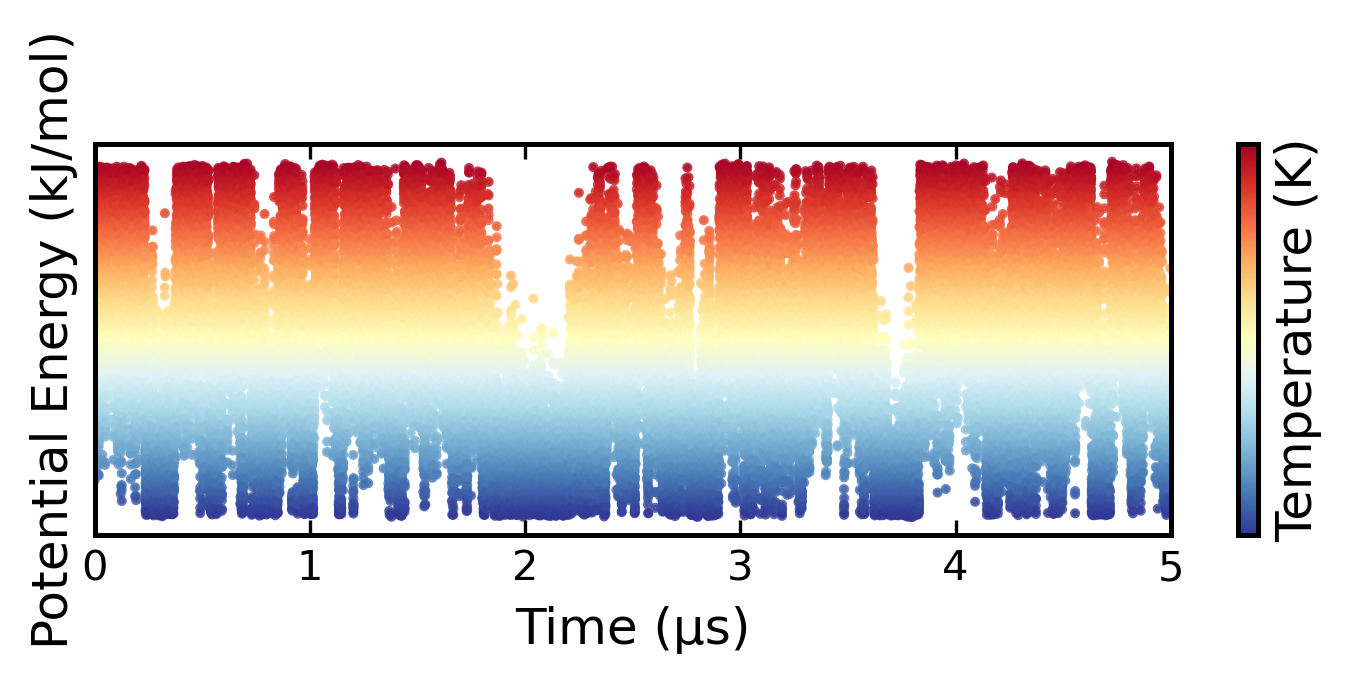

In [ ]:


# --- Load a simulation ---
sim = 4
data = read_colvar(path + f'COLVAR.{sim}')[::10]   # subsample

# Time (ps → μs)
time_data = data[:, 0] / 1e6
mask = time_data <= 5.0
time_data = time_data[mask]
data = data[mask]

# Extract values
energy = data[:, 1]      # potential energy (kJ/mol)
temp = data[:, 1]        # temperature (K or dimensionless)

# --- Normalize temperature for colormap ---
norm = mpl.colors.Normalize(vmin=temp.min(), vmax=temp.max())
cmap = mpl.cm.get_cmap("RdYlBu_r")

# --- Plot ---
plt.figure(figsize=(5, 2.))

plt.scatter(
    time_data,
    energy,
    c=temp,
    cmap=cmap,
    norm=norm,
    s=2,
    alpha=0.8,
    rasterized=True
)

plt.xlabel("Time (μs)")
plt.yticks(ticks=[], labels = [])
plt.ylabel("Potential Energy (kJ/mol)")
plt.grid(None)

# Colorbar
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap))
cbar.set_ticks([])             # remove tick marks
cbar.set_ticklabels([])        # remove tick labels
cbar.set_label("Temperature (K)")

plt.xlim(0, 5)

plt.tight_layout()
plt.savefig(output_path+'fig1_time_vs_ene.pdf')


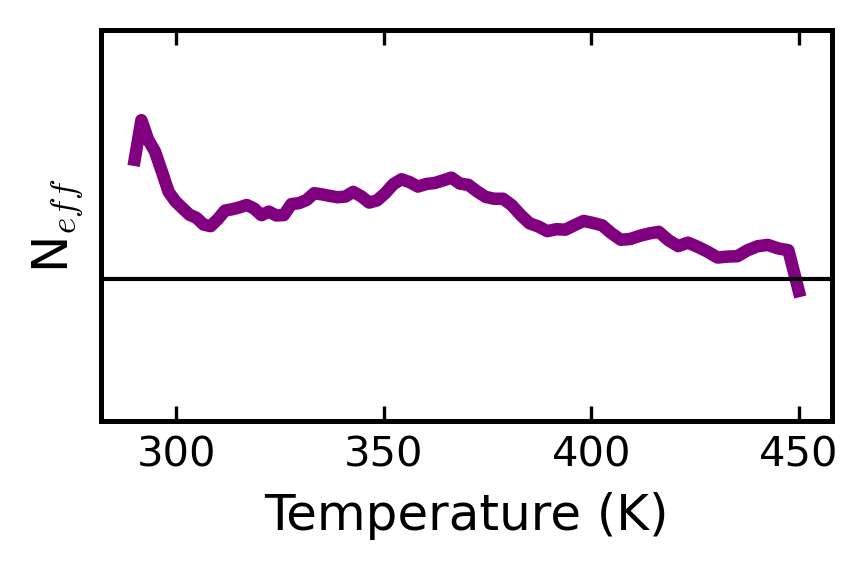

In [33]:
# effective sample size across temperatures for each simulation

sim=4

kb=0.008314
T0 = 300
kbt = kb*T0

temps = np.geomspace(290,450,80)

# Load data
data = read_colvar(path+f'COLVAR.{sim}')

# Time arrays in μs
time_data = data[:, 0] / 1e6        # ps -> μs
# Apply cutoff at 5 µs
mask_data = time_data <= 5.0 
time_data = time_data[mask_data]
data = data[mask_data] 
bias = data[:,2]
ene = data[:,1] # U

neffs = []
for T in temps:
    # log weights
    logw = (bias + (1 - T0 / T) * ene) / (kb * T0)
    # sampling efficiency
    shift = np.log(len(logw))
    neff = np.exp(2 * logsumexp(logw) - logsumexp(2 * logw) - shift)
    neffs.append(neff)

# Calculate a quality score (fraction of temps above 1/n_temp_steps)
neffs = np.array(neffs)


# --- Plot ---
plt.figure(figsize=(3, 2.))

plt.plot(temps, neffs, color = 'purple', linewidth=3)
plt.yticks(ticks=[],labels = [])
plt.xlabel("Temperature (K)")
plt.ylabel("N$_{eff}$")
plt.grid(None)

plt.axhline(1/temps.shape[0], color = 'black',linestyle='solid', linewidth=1.)
plt.ylim(0, np.max(neffs)*1.3)


plt.tight_layout()
plt.savefig(output_path+'fig1_neff.pdf')
